

Run with:
```
  PATH=/home/centos/miniconda2/bin:$PATH PYSPARK_DRIVER_PYTHON=jupyter PYSPARK_DRIVER_PYTHON_OPTS="notebook --no-browser --ip 0.0.0.0" pyspark
```

In [1]:
%matplotlib inline
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc.setLogLevel("WARN")

In [3]:
%%time
print("Load start")
print(datetime.datetime.now())

df = spark.read.parquet("swift://cts-gaia.Nebula/gaia-dr1.parquet")
print("Load complete")
print(datetime.datetime.now())

Load start
2017-01-12 05:56:47.498506
Load complete
2017-01-12 05:59:58.498662
CPU times: user 26.4 ms, sys: 7.96 ms, total: 34.3 ms
Wall time: 3min 11s


In [16]:
%%time 

#
# It's faster to map over partitions, turn the records into a numpy array,
# then work with that than to map over each record individually.
#
def partition_histogram(partition):
    
    phot_g_mean_mag = np.fromiter((x.phot_g_mean_mag for x in partition),
                                 np.float)
    H, _ = np.histogram(phot_g_mean_mag, bins=bins.value)

    # This must return an iterable to spark.
    # If the entire partition reduces to one object, that object
    # must be inside a list.
    return [H]

bins = sc.broadcast(np.linspace(10,15,15))
H = df.filter("htm_id=11056").select("phot_g_mean_mag").rdd.mapPartitions(partition_histogram).sum()
print(H)


[  47   72  104  173  221  303  421  601  830 1184 1514 2129 2631 3533]
CPU times: user 7.55 ms, sys: 4.27 ms, total: 11.8 ms
Wall time: 4.69 s


In [6]:
%%time
def spatial_histogram(partition):
    

    coord_array = np.asarray( [(x.ra, x.dec) for x in partition],
                             dtype=(np.float, np.float))
    ra_bins = np.linspace(0,360,500)
    dec_bins = np.linspace(-90,90,250)
    if len(coord_array) == 0:
        return []
    
    H, _ = np.histogramdd(coord_array, bins=(ra_bins, dec_bins))

    # This must return an iterable to spark.
    # If the entire partition reduces to one object, that object
    # must be inside a list.
    return [H]

# Without the coalesce(), executors would run out of memory. 
H_map = df.select("ra", "dec").rdd.coalesce(100).mapPartitions(spatial_histogram).sum()

CPU times: user 92.7 ms, sys: 71 ms, total: 164 ms
Wall time: 8min 8s


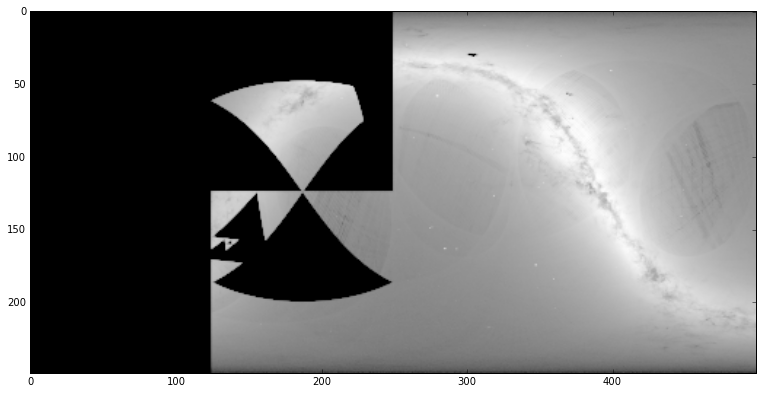

In [15]:
plt.figure(1, figsize=(13,8))
plt.imshow(np.log(H_map.T + 1), cmap='gray') #, vmax=0.5*np.max(H_map))

In [12]:
np.max(H_map)

209568.0